In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [26]:
data_path = '../Classification/output/regions/north_america_australia/genral_labeled_data_with_relative_traffic_rates/Entertainment/extended_data/usa.csv'
data = pd.read_csv(data_path)

In [27]:
def create_sequences(data, seq_length):
    """Create sequences for LSTM input"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def preprocess_data(data, seq_length=30):
    data = data.set_index('date')
    data = data['score']
    data.index = pd.to_datetime(data.index)
    
    # Normalize the data
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))
    
    # Split the data
    train_data = data_scaled[data.index <= '2014-11-11']
    test_data = data_scaled[data.index > '2016-11-28']
    
    # Create sequences
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)
    
    return X_train, y_train, X_test, y_test, scaler

def create_model(seq_length):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


In [28]:
seq_length = 30

X_train, y_train, X_test, y_test, scaler = preprocess_data(data, seq_length)

model = create_model(seq_length)
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

predictions = model.predict(X_test)
print("predictions:", predictions)

predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

Epoch 1/50


c:\Users\alkrd\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1873
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0184
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0150
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0151
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0151
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0152
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0147
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0142
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0150
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0156
Epoch 16/50
32/32 ━━━━━━━━━━━

In [29]:
def test_on_time_range(model, data, start_date, end_date, window_size=30):
    filtered_data = data.loc[(data.index >= start_date) & (data.index <= end_date)]
    
    if len(filtered_data) < window_size:
        raise ValueError("Not enough data in the selected time range for testing.")
    
    sequences = []
    for i in range(len(filtered_data) - window_size):
        sequences.append(filtered_data.iloc[i:i+window_size].values)
    X_test = np.array(sequences)
    
    predictions = model.predict(X_test)
    return predictions, filtered_data[window_size:]

In [ ]:
predictions, actual_data = test_on_time_range(
    model, 
    data.set_index('date')['score'], 
    start_date='2017-01-01', 
    end_date='2017-05-04'
)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


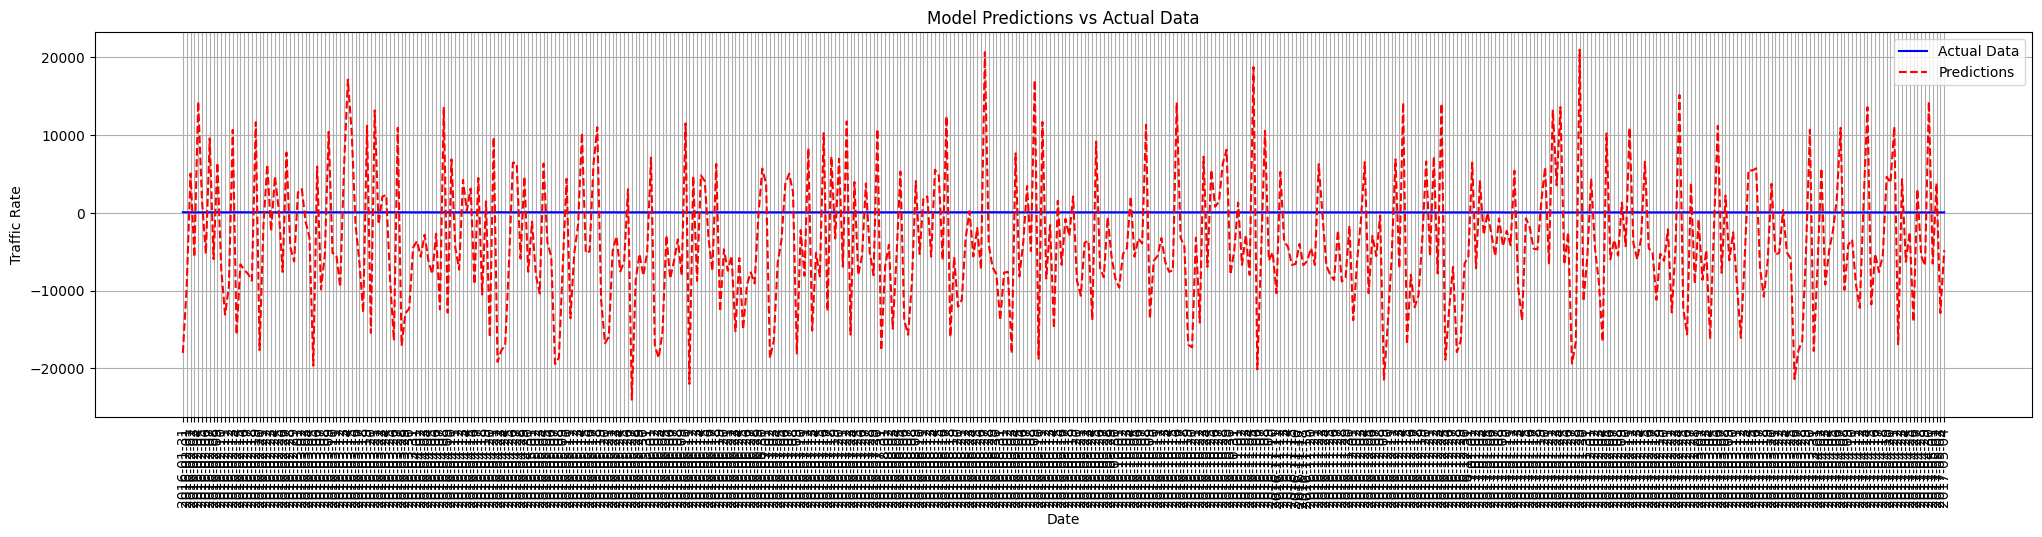

In [31]:
def plot_predictions(predictions, actual_data, title="Model Predictions vs Actual Data"):
    plt.figure(figsize=(25, 5))
    plt.plot(actual_data.index, actual_data.values, label="Actual Data", color='blue')
    prediction_dates = actual_data.index[:len(predictions)]
    plt.plot(prediction_dates, predictions, label="Predictions", color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Traffic Rate")
    plt.xticks( rotation=90)
    plt.legend()
    plt.grid()
    plt.show()


plot_predictions(predictions, actual_data)